In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from scipy import stats

plt.style.use("seaborn")
sns.set_context("talk")
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv("../Crashes_in_DC.csv")

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_detail = pd.read_csv("../Crash_Details_Table.csv")

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.REPORTDATE = pd.to_datetime(df.REPORTDATE)
df.FROMDATE = pd.to_datetime(df.FROMDATE)
df.TODATE = pd.to_datetime(df.TODATE)

In [5]:
df["report_second"] = df.REPORTDATE.apply(lambda date: date.second)
df["report_minute"] = df.REPORTDATE.apply(lambda date: date.minute)
df["report_hour"] = df.REPORTDATE.apply(lambda date: date.hour)
df["report_month"] = df.REPORTDATE.apply(lambda date: date.month)
df["report_year"] = df.REPORTDATE.apply(lambda date: date.year)
df["report_date"] = df.REPORTDATE.apply(lambda date: date.date)
df["report_day_of_week"] = df.REPORTDATE.apply(lambda date: date.dayofweek)
df["quadrant"] = df.ADDRESS.str.extract(r" ([NS][WE])\b")
df["ward"] = df.WARD.str.extract(r"([1-8])")
df["weekend"] = df.report_day_of_week >=5

In [6]:
df_merged = pd.merge(df, df_detail, how="inner", on="CRIMEID")
df_merged = df_merged.loc[~((df_merged.report_hour==5) & (df_merged.report_minute==0) & (df_merged.report_second==0))]
df_merged = df_merged.loc[((df_merged.report_year>2015)&(df_merged.report_year<=2019))]

In [7]:
df_merged.shape

(166403, 78)

In [8]:
df_merged.loc[df_merged.AGE<=13] = np.nan

In [9]:
df = df.loc[((df.report_year>2015)&(df.report_year<=2019))]

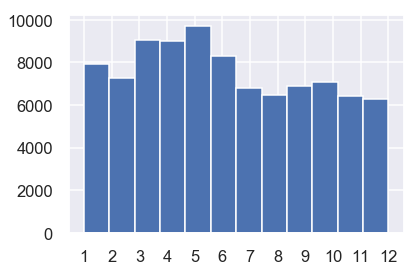

In [10]:
df.report_month.hist(bins=12)
plt.xticks(range(1, 13))
plt.show()

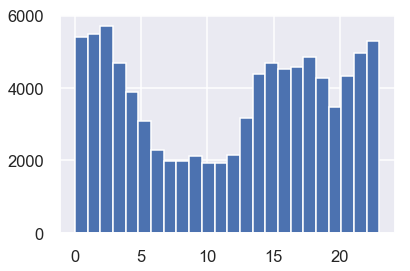

In [11]:
df_except_five_oclock = df.loc[~((df.report_hour==5) & (df.report_minute==0) & (df.report_second==0))]
df_except_five_oclock.report_hour.hist(bins=24)
plt.show()

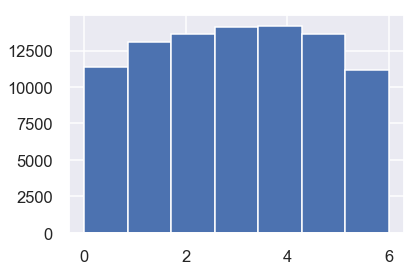

In [12]:
day_of_week = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
df_except_five_oclock.report_day_of_week.hist(bins=7)
plt.show()

In [13]:
df.quadrant.value_counts()

NW    41175
NE    22927
SE    18115
SW     3112
Name: quadrant, dtype: int64

In [14]:
df.groupby("quadrant")[["X", "Y"]].agg(["max","min"])

X                     Y           
                max        min        max        min
quadrant                                            
NE       -76.909549 -77.056082  38.970359  38.872437
NW       -76.939845 -77.116031  38.992847  38.870752
SE       -76.911472 -77.034903  38.919263  38.818379
SW       -76.981401 -77.055360  38.905660  38.808889

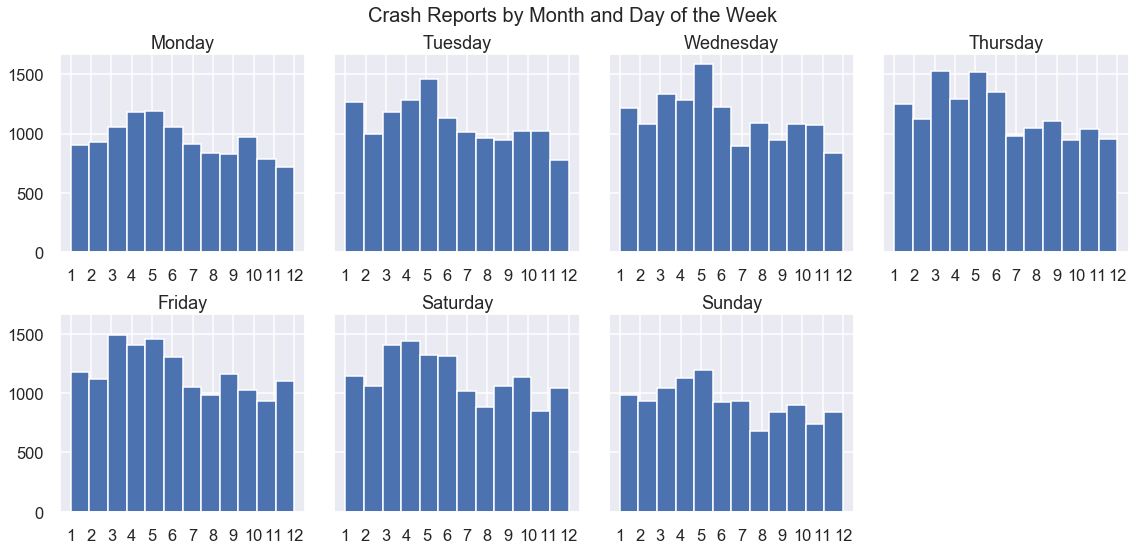

In [15]:
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Crash Reports by Month and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].hist(df.loc[df.report_day_of_week==i,"report_month"], bins=12)
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(1,13))

ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])
fig.subplots_adjust(hspace=0.2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.patch.set_alpha(0)

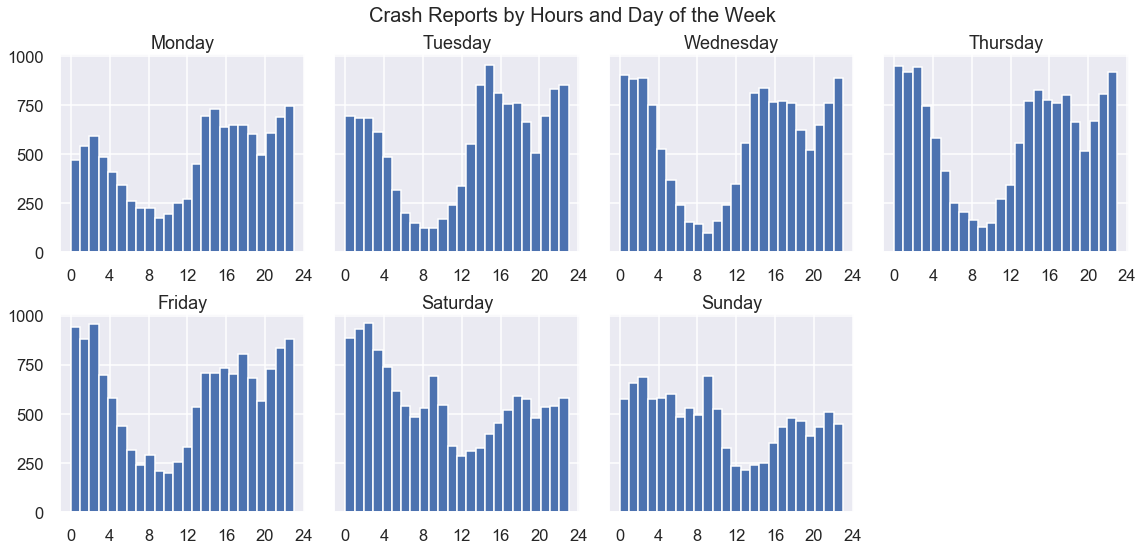

In [16]:
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Crash Reports by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].hist(df_except_five_oclock.loc[df_except_five_oclock.report_day_of_week==i,"report_hour"], bins=24)
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 25, 4))

ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])
fig.subplots_adjust(hspace=0.2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.patch.set_alpha(0)
plt.savefig("../Images/crash_report_hour_day_of_week")

In [17]:
quadrants = ["NW", "NE", "SE", "SW"]

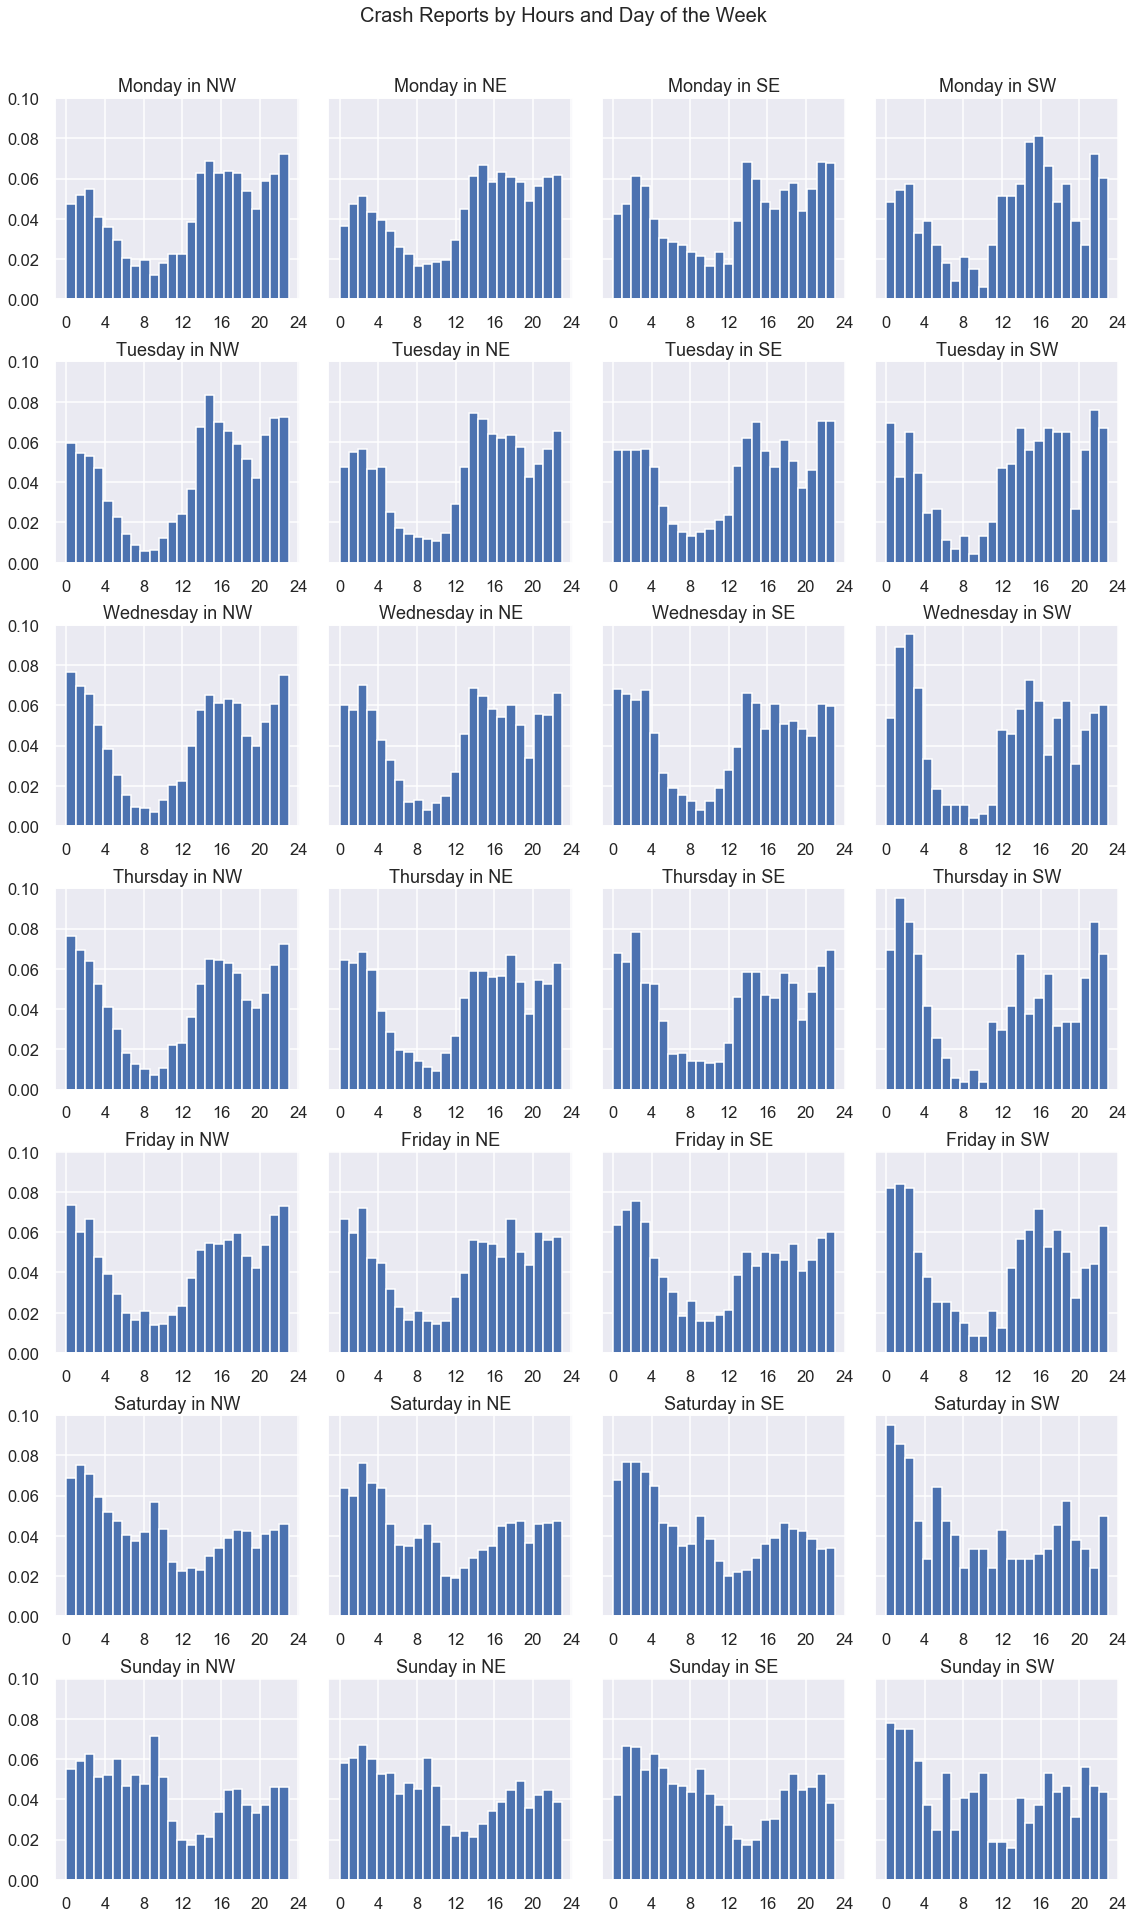

In [18]:
fig, ax = plt.subplots(7,4, sharey=True, figsize=(16,28))
fig.suptitle("Crash Reports by Hours and Day of the Week", fontsize=20)
for i in range(28):
    row = int(i/4)
    col = i%4
    ax[row, col].hist(df_except_five_oclock.loc[(df_except_five_oclock.report_day_of_week==row)
                                                &(df_except_five_oclock.quadrant==quadrants[col]),
                                                "report_hour"], bins=24, density=True)
    ax[row, col].title.set_text(day_of_week[row]+" in "+quadrants[col])
    ax[row, col].set_xticks(range(0, 25, 4))

fig.subplots_adjust(hspace=0.2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.patch.set_alpha(0)

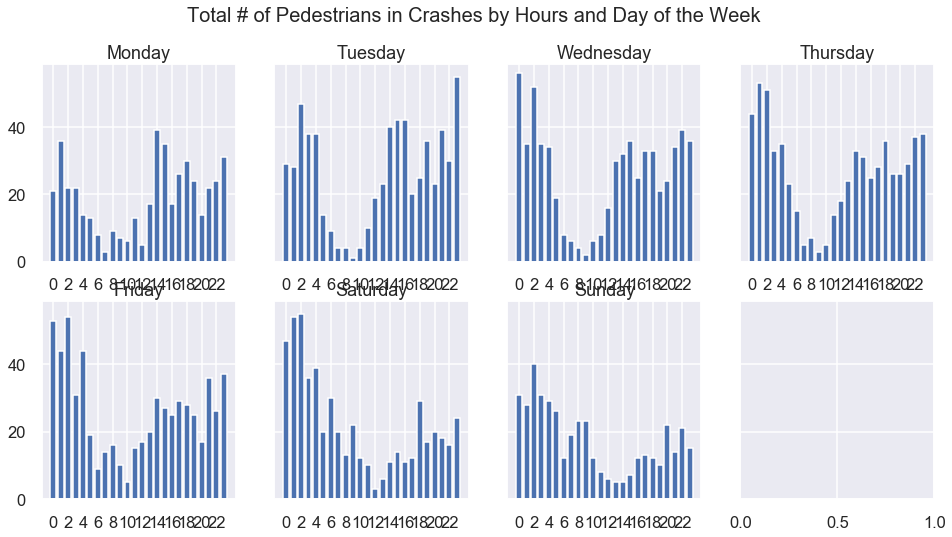

In [19]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_PEDESTRIANS", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # of Pedestrians in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

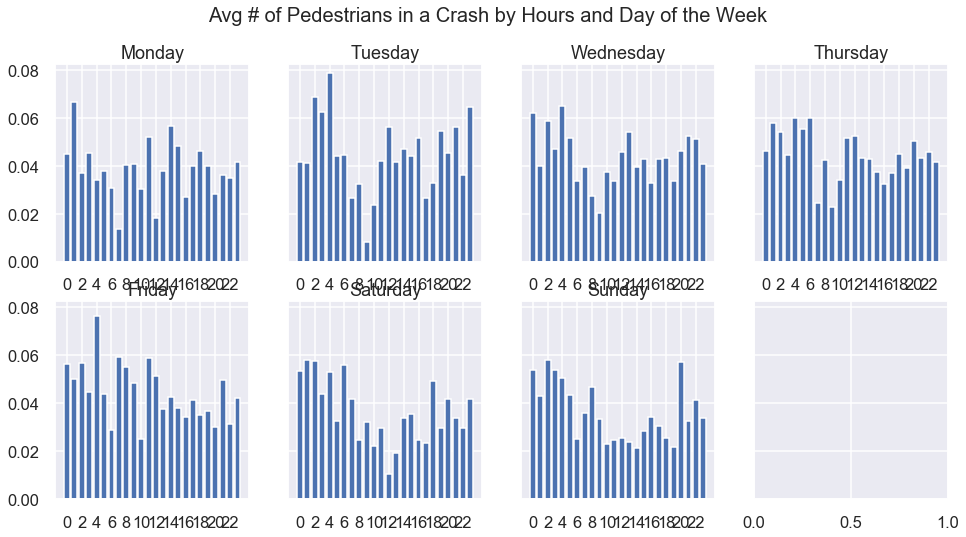

In [20]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_PEDESTRIANS", aggfunc=np.mean)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Avg # of Pedestrians in a Crash by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

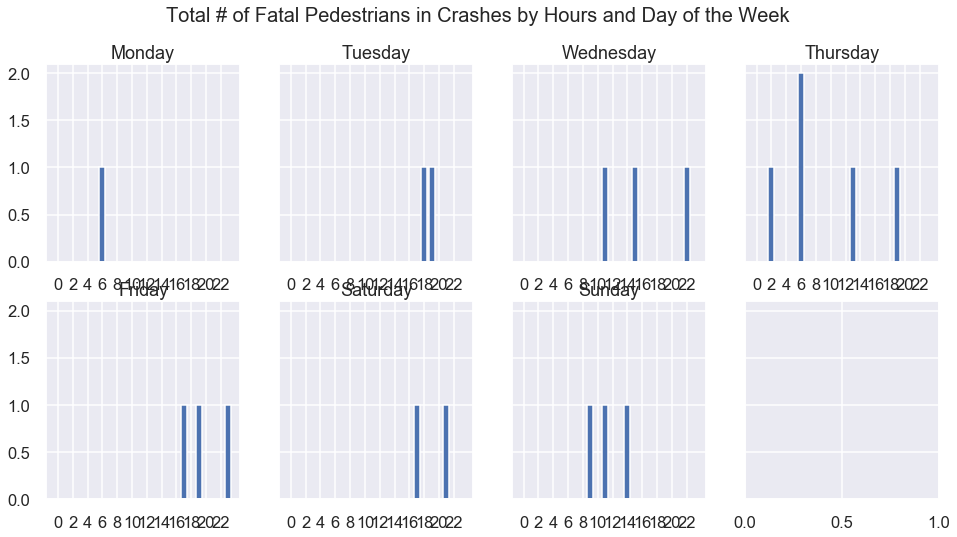

In [21]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="FATAL_PEDESTRIAN", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # of Fatal Pedestrians in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

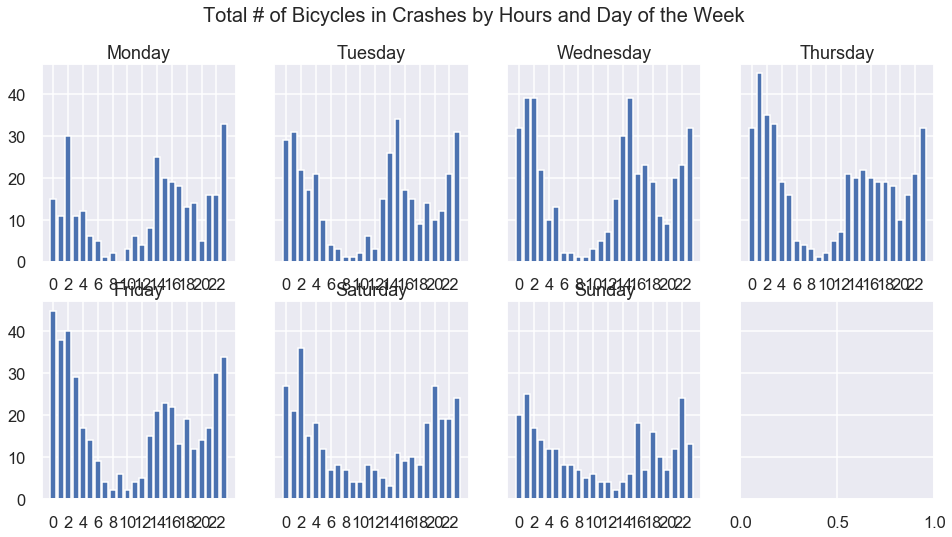

In [22]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_BICYCLES", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # of Bicycles in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

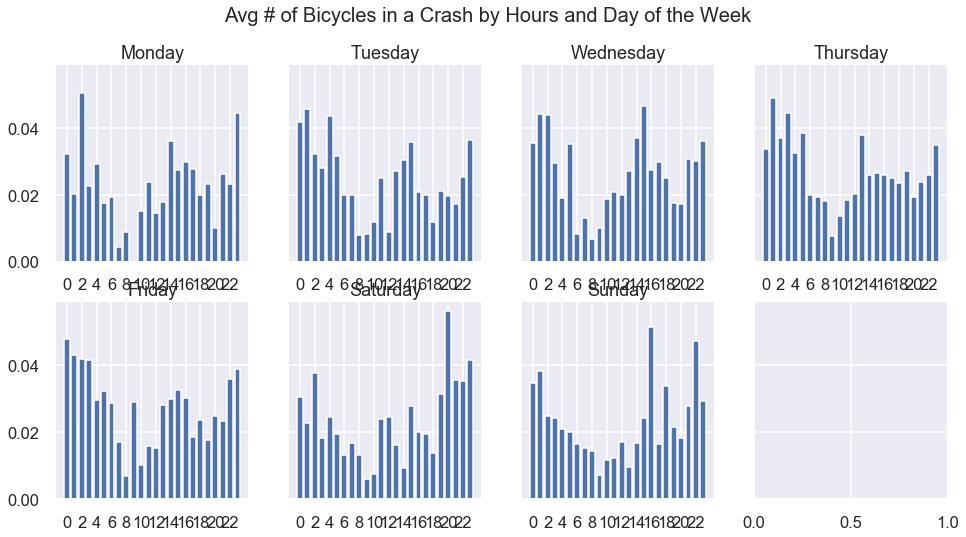

In [23]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_BICYCLES", aggfunc=np.mean)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Avg # of Bicycles in a Crash by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

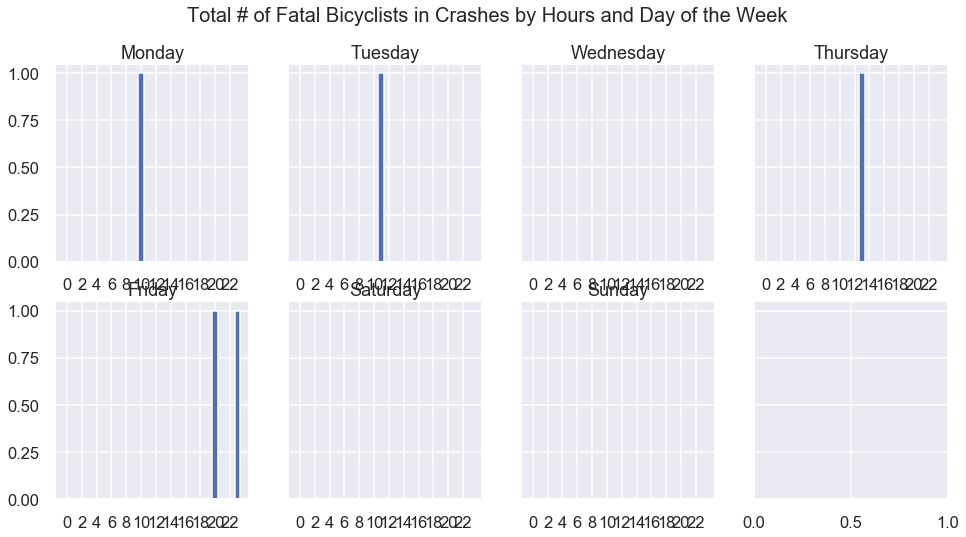

In [24]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="FATAL_BICYCLIST", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # of Fatal Bicyclists in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

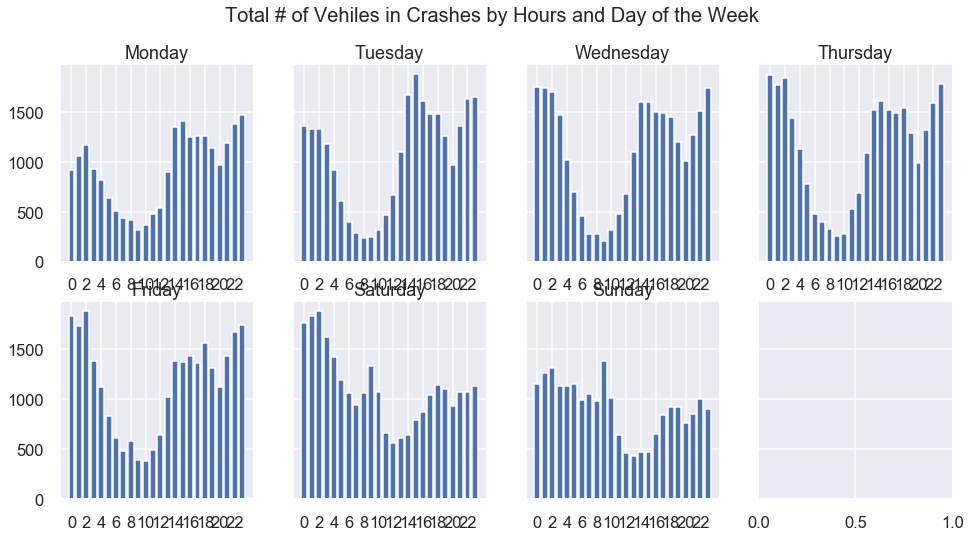

In [25]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_VEHICLES", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # of Vehiles in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

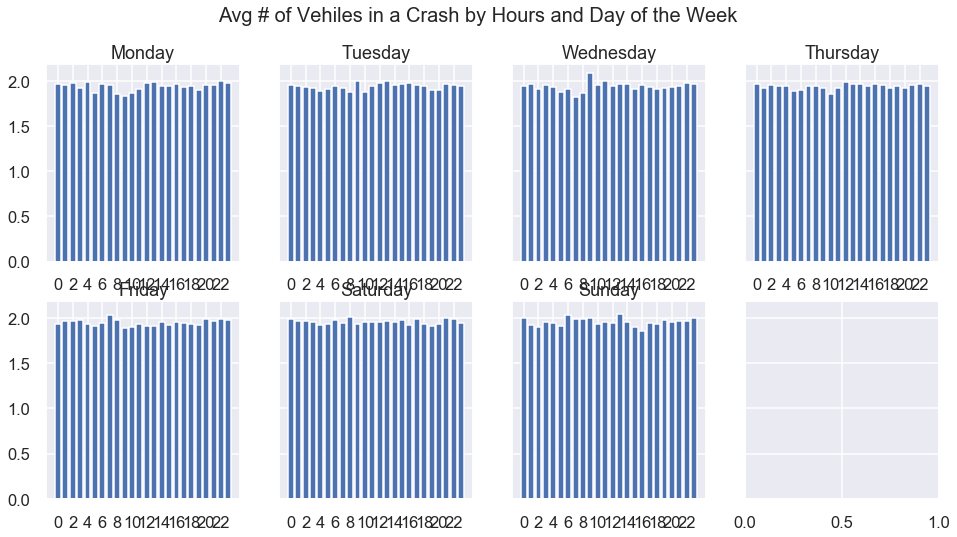

In [26]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_VEHICLES", aggfunc=np.mean)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Avg # of Vehiles in a Crash by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

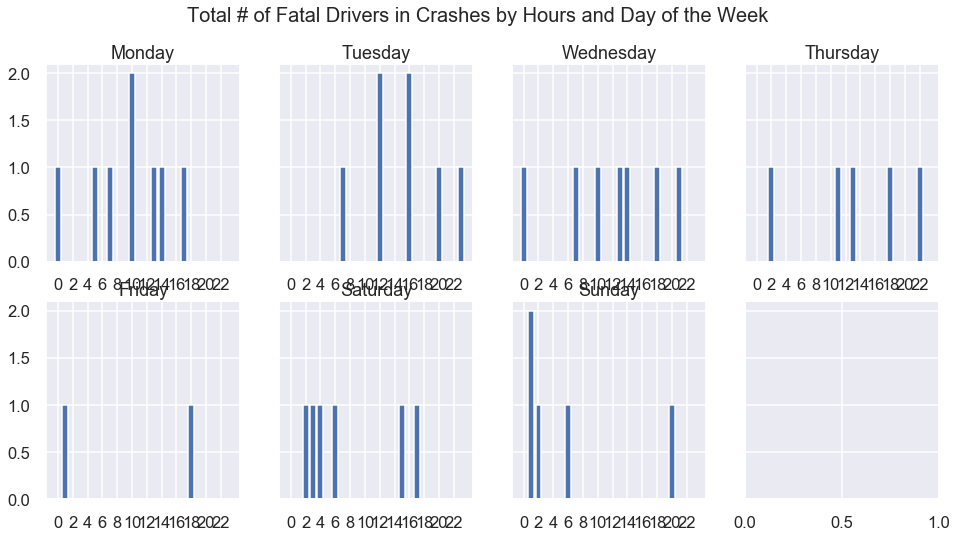

In [27]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="FATAL_DRIVER", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # of Fatal Drivers in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

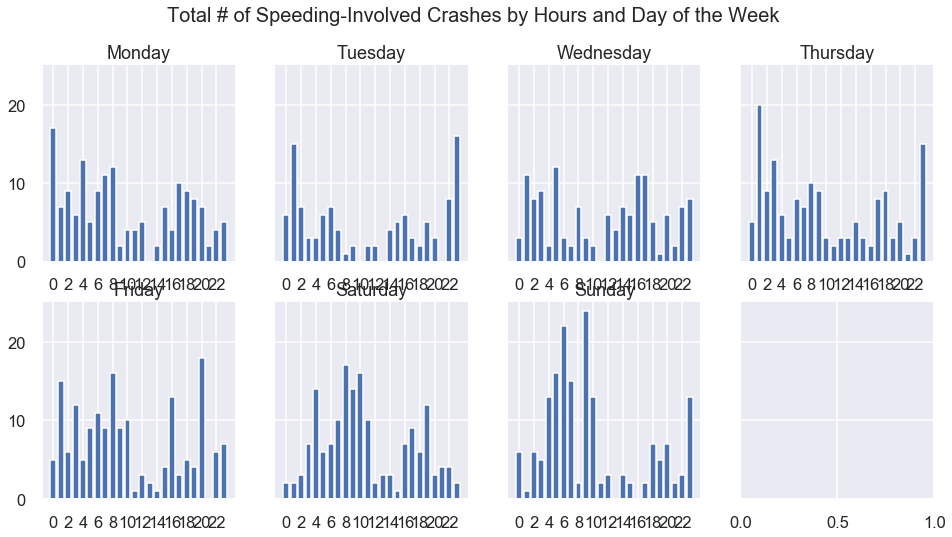

In [28]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="SPEEDING_INVOLVED", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # of Speeding-Involved Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

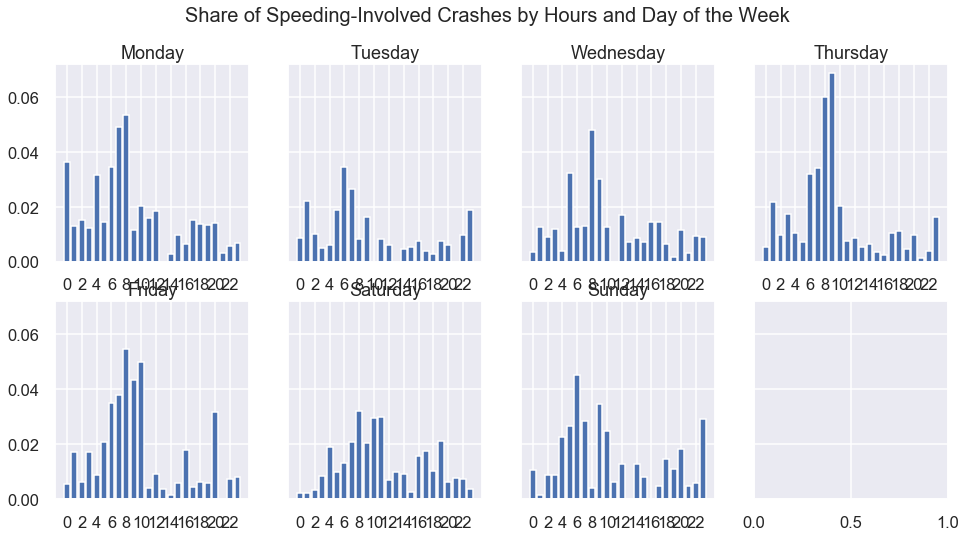

In [29]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="SPEEDING_INVOLVED", aggfunc=np.mean)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Share of Speeding-Involved Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

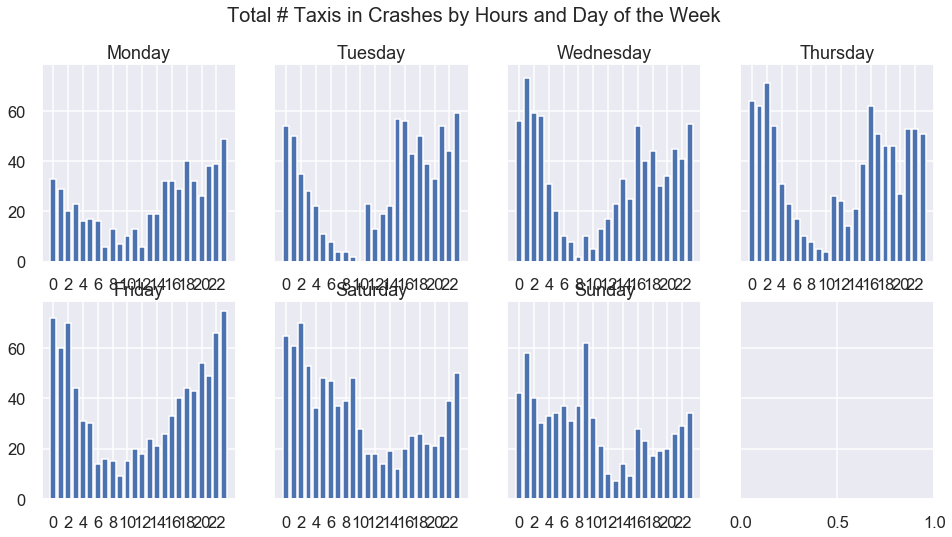

In [30]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_TAXIS", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # Taxis in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

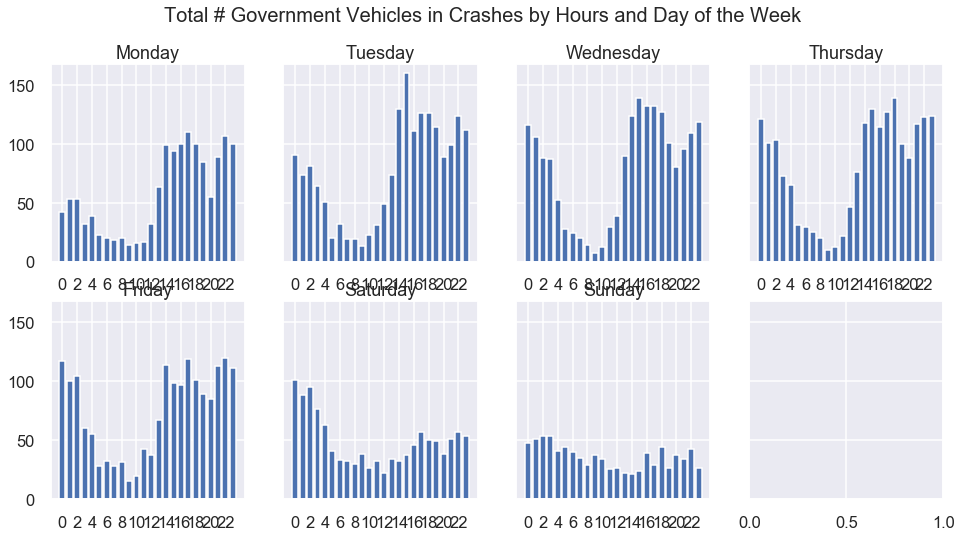

In [31]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_GOVERNMENT", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # Government Vehicles in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

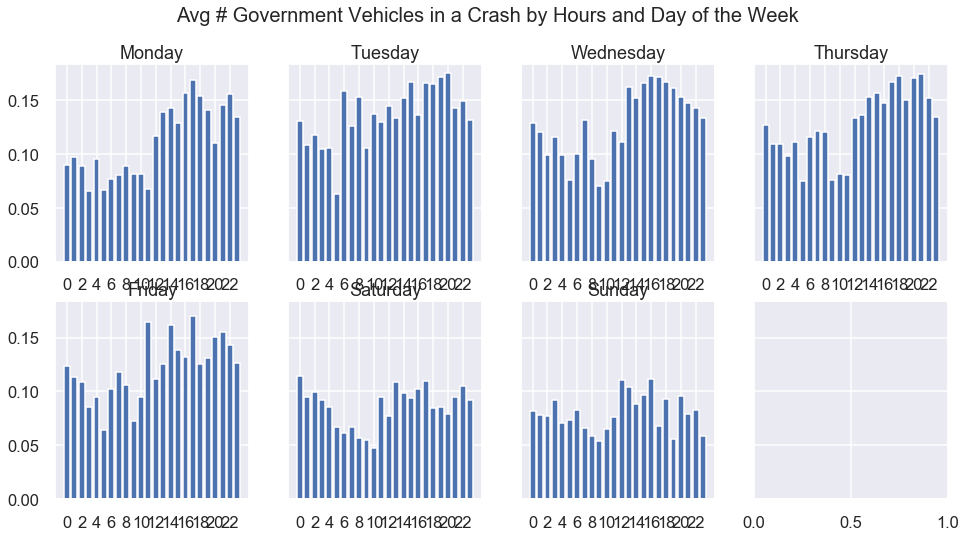

In [32]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="TOTAL_GOVERNMENT", aggfunc=np.mean)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Avg # Government Vehicles in a Crash by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

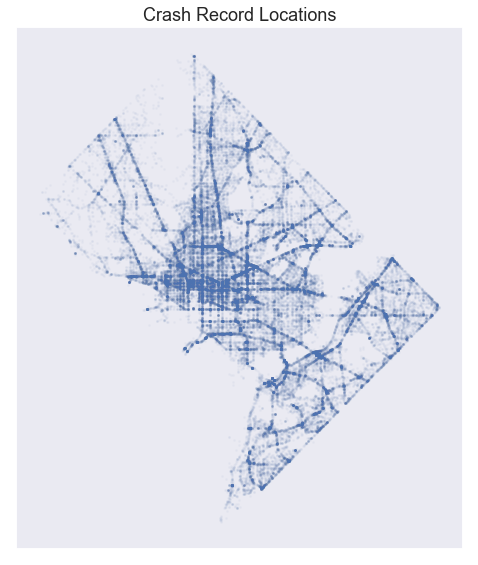

<Figure size 432x288 with 0 Axes>

In [34]:
fig = plt.figure(figsize=(8,9.6))
plt.title("Crash Record Locations")
fig.set_alpha(0.0)
plt.scatter(df_except_five_oclock.X, df_except_five_oclock.Y, alpha=0.03, s=2)
plt.xticks([])
plt.yticks([])

plt.figure()
plt.show()

fig.savefig("../Images/crash_map.png")


In [ ]:
m = Basemap(-77.12, 38.8, -76.9, 39, projection='merc')

In [ ]:
x, y = m(df_except_five_oclock.X.tolist(), df_except_five_oclock.Y.tolist())

In [ ]:
plt.figure(figsize=(12,10))
m.scatter(x, y, s=3, alpha=0.01)

In [ ]:
df_except_five_oclock.loc[:, "major_route"] = df_except_five_oclock.ROUTEID.isin(list(df_except_five_oclock.ROUTEID.value_counts().head(100).index))
df_major_route = df_except_five_oclock[df_except_five_oclock.ROUTEID.isin(list(df_except_five_oclock.ROUTEID.value_counts().head(100).index))]
plt.figure(figsize=(12,10))
x, y = m(df_major_route.X.tolist(), df_major_route.Y.tolist())
m.scatter(x, y, s=3, alpha=0.02)
fig.patch.set_alpha(0)


In [ ]:
x1, y1 = m(df_except_five_oclock.loc[df_except_five_oclock.weekend, "X"].tolist(), df_except_five_oclock.loc[df_except_five_oclock.weekend, "Y"].tolist())
x2, y2 = m(df_except_five_oclock.loc[df_except_five_oclock.weekend==False, "X"].tolist(), df_except_five_oclock.loc[df_except_five_oclock.weekend==False, "Y"].tolist())

In [ ]:
plt.figure(figsize=(12,10))
m.scatter(x1, y1, s=3, alpha=0.005, c="blue")
m.scatter(x2, y2, s=3, alpha=0.005, c="red")

In [ ]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="major_route", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("# Crashes on Major Routes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

In [ ]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="major_route", aggfunc=np.mean)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Share of Major Routes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

In [ ]:
df_except_five_oclock["log_off_intersection"] = df_except_five_oclock.OFFINTERSECTION.apply(lambda x: np.nan if (x<=0 or x>10000) else np.log10(x))

In [ ]:
df_except_five_oclock["log_off_intersection"].describe()

In [ ]:
df_except_five_oclock["log_off_intersection"].hist(bins=200)

In [ ]:
df_except_five_oclock.log_off_intersection = df_except_five_oclock.log_off_intersection.apply(lambda x: x if x>=0 else np.nan)

In [ ]:
df_except_five_oclock["log_off_intersection"].hist(bins=200)

In [ ]:
df_except_five_oclock.loc[df_except_five_oclock.weekend, "log_off_intersection"].hist(bins=200, alpha=0.2)
df_except_five_oclock.loc[df_except_five_oclock.weekend==False, "log_off_intersection"].hist(bins=200, alpha=0.2)

In [ ]:
pivot = pd.pivot_table(df_except_five_oclock, index="report_hour", columns="report_day_of_week", values="log_off_intersection", aggfunc=np.mean)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("AvgLog Distance from Intersection by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

In [ ]:
pivot = pd.pivot_table(df_except_five_oclock, index="weekend", columns="major_route", values="SPEEDING_INVOLVED", aggfunc=np.mean)
pivot.plot(kind="bar")

In [ ]:
pivot = pd.pivot_table(df_except_five_oclock, index="weekend", columns="major_route", values="SPEEDING_INVOLVED", aggfunc=[np.mean, len])
pivot

In [ ]:
diff = pivot["mean"][True]-pivot["mean"][False]

In [ ]:
p_avg = (pivot["len"][True] * pivot["mean"][True] + pivot["len"][False] * pivot["mean"][False]) / (pivot["len"][True] + pivot["len"][False])

In [ ]:
denom = np.sqrt(p_avg * (1-p_avg) * (1/pivot["len"][True] + 1/pivot["len"][False]))

In [ ]:
diff / denom

In [ ]:
df_merged["license"] = df_merged.LICENSEPLATESTATE
df_merged.loc[np.logical_not(df_merged.license.isin(["DC", "VA", "MD"])), "license"] = "other"

In [ ]:
dc = df_merged.pivot_table(values="ADDRESS", columns="license", index="report_date", aggfunc="count")["DC"]
va = df_merged.pivot_table(values="ADDRESS", columns="license", index="report_date", aggfunc="count")["VA"]
md = df_merged.pivot_table(values="ADDRESS", columns="license", index="report_date", aggfunc="count")["MD"]
others = df_merged.pivot_table(values="ADDRESS", columns="license", index="report_date", aggfunc="count")["other"]

In [ ]:
dc.hist(bins=20, alpha=0.4)
va.hist(bins=20, alpha=0.4)
md.hist(bins=20, alpha=0.4)
others.hist(bins=20, alpha=0.4)
plt.legend(["dc", "va", "md", "others"])

In [ ]:
stats.ttest_ind(dc, va, equal_var=False, nan_policy="omit")

In [ ]:
stats.ttest_ind(dc, md, equal_var=False, nan_policy="omit")

In [ ]:
stats.ttest_ind(va, md, equal_var=False, nan_policy="omit")

In [ ]:
df_merged.shape

In [ ]:
df_merged["ticket"] = df_merged.TICKETISSUED == "Y"
df_merged["speeding"] = df_merged.SPEEDING == "Y"
df_merged["impaired"] = df_merged.IMPAIRED == "Y"
df_merged["injury"] = (df_merged.FATAL == "Y") + (df_merged.MAJORINJURY == "Y") + (df_merged.MINORINJURY == "Y")

In [ ]:
pivot = df_merged.pivot_table(values = ["ticket", "speeding", "impaired", "injury"], columns="license", aggfunc=["mean", "count"])
pivot

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.suptitle("Drivers' Conditions in Crashes by Origin State", fontsize=25)
for i, topic in enumerate(["ticket", "speeding", "impaired", "injury"]):
    pivot.loc[topic, "mean"].plot(kind="bar", ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(topic, size=20)
    axes[i//2, i%2].set_xticklabels(["DC", "MD", "VA", "Others"], fontsize=15, rotation=0)
    axes[i//2, i%2].set_xlabel(xlabel="")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.3)
fig.patch.set_alpha(0)
plt.savefig("Images/driver_behavior_state")

In [ ]:
pivot.loc["speeding", "mean"].plot(kind="bar")

In [ ]:
pivot.loc["ticket", "mean"].plot(kind="bar")

In [ ]:
pivot.loc["impaired", "mean"].plot(kind="bar")

In [ ]:
pivot.loc["injury", "mean"].plot(kind="bar")

In [ ]:
def prop_test(license1, license2, topic):

    diff = pivot["mean"][license1][topic] - pivot["mean"][license2][topic]
    p_avg = ((pivot["count"][license1][topic] * pivot["mean"][license1][topic] 
              + pivot["count"][license2][topic] * pivot["mean"][license2][topic]) 
             / (pivot["count"][license1][topic] + pivot["count"][license2][topic]))
    denom = np.sqrt(p_avg * (1-p_avg) * (1/pivot["count"][license1][topic] + 1/pivot["count"][license2][topic]))
    z_score = diff / denom
    p_value = stats.norm.sf(abs(z_score))*2
    return "z-score: {}, p-value: {}".format(z_score, p_value)

In [ ]:
for topic in ["ticket", "speeding", "impaired", "injury"]:
    for state1 in ["DC", "MD", "VA"]:
        for state2 in ["DC", "MD", "VA"]:
            print(state1, state2, topic)
            print(prop_test(state1, state2, topic))

In [ ]:
prop_test("DC", "VA", "speeding")

In [ ]:
prop_test("DC", "VA", "impaired")

In [ ]:
df_merged["va"] = 0
df_merged.loc[df_merged.license=="VA", "va"] = 1
df_merged["md"] = 0
df_merged.loc[df_merged.license=="MD", "md"] = 1
df_merged["dc"] = 0
df_merged.loc[df_merged.license=="DC", "dc"] = 1

df_merged[["va", "md", "dc"]].describe()

In [ ]:
pivot = pd.pivot_table(df_merged, index="report_hour", columns="report_day_of_week", values="va", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Share of Speeding-Involved Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

In [ ]:
pivot = pd.pivot_table(df_merged, index="report_hour", columns="report_day_of_week", values="md", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Share of Speeding-Involved Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

In [ ]:
pivot = pd.pivot_table(df_merged, index="report_hour", columns="report_day_of_week", values="dc", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Share of Speeding-Involved Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))

In [ ]:
df_merged.groupby("license").AGE.hist(bins=20, alpha=0.3)
plt.legend(["DC", "MD", "VA", "Others"])

In [ ]:
stats.ttest_ind(df_merged.loc[df_merged.license=="DC", "AGE"], df_merged.loc[df_merged.license=="MD", "AGE"], equal_var=False)

In [ ]:
df_person = df_merged.groupby(["license","PERSONID"])[["ticket", "speeding"]].agg(["sum","count"])

In [ ]:
df_person.loc["DC"].ticket["sum"].hist(bins=3)

In [ ]:
df_person.loc["VA"].ticket["sum"].hist(bins=3)

In [ ]:
df_person.loc["MD"].ticket["sum"].hist(bins=3)

In [ ]:
pivot = pd.pivot_table(df_merged, index="report_hour", columns="report_day_of_week", values="impaired", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Impaired in Crashes by Hours and Day of the Week", fontsize=25)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 4))

ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])
fig.subplots_adjust(hspace=0.2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.patch.set_alpha(0)
plt.savefig("Images/impaired_hour")

In [ ]:
pivot = pd.pivot_table(df_merged, index="report_hour", columns="report_day_of_week", values="ticket", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Tickets Given in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 4))

fig.subplots_adjust(hspace=0.2)
ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.patch.set_alpha(0)

In [ ]:
pivot = pd.pivot_table(df_merged, index="report_hour", columns="report_day_of_week", values="injury", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Injuries in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 4))

fig.subplots_adjust(hspace=0.2)
ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.patch.set_alpha(0)

In [ ]:
df_merged.loc[df_merged.ticket, "speeding"].sum()

In [ ]:
df_merged.speeding.sum()

In [ ]:
df_merged.groupby("license")["X", "Y"].describe()

In [ ]:
df_merged.loc[df_merged.impaired].groupby("license")["X", "Y"].describe()

In [ ]:
plt.figure(figsize=(12,10))
x1, y1 = m(df_merged.loc[df_merged.license=="DC"].X.tolist(), df_merged.loc[df_merged.license=="DC"].Y.tolist())
x2, y2 = m(df_merged.loc[df_merged.license=="MD"].X.tolist(), df_merged.loc[df_merged.license=="MD"].Y.tolist())
x3, y3 = m(df_merged.loc[df_merged.license=="VA"].X.tolist(), df_merged.loc[df_merged.license=="VA"].Y.tolist())


m.scatter(x1, y1, s=3, alpha=0.01, c="green")
m.scatter(x2, y2, s=3, alpha=0.01, c="red")
m.scatter(x3, y3, s=3, alpha=0.01, c="blue")

plt.title("Crash Reports with Drivers Impaired")
plt.legend(["DC", "MD", "VA"])

fig.patch.set_alpha(0)

In [ ]:
plt.figure(figsize=(12,10))
x1, y1 = m(df_merged.loc[((df_merged.impaired) & (df_merged.license=="DC"))].X.tolist(), df_merged.loc[((df_merged.impaired) & (df_merged.license=="DC"))].Y.tolist())
x2, y2 = m(df_merged.loc[((df_merged.impaired) & (df_merged.license=="MD"))].X.tolist(), df_merged.loc[((df_merged.impaired) & (df_merged.license=="MD"))].Y.tolist())
x3, y3 = m(df_merged.loc[((df_merged.impaired) & (df_merged.license=="VA"))].X.tolist(), df_merged.loc[((df_merged.impaired) & (df_merged.license=="VA"))].Y.tolist())

m.scatter(x1, y1, s=3, alpha=0.3, c="green")
m.scatter(x2, y2, s=3, alpha=0.3, c="red")
m.scatter(x3, y3, s=3, alpha=0.3, c="blue")

plt.title("Crash Reports with Drivers Impaired")
plt.legend(["DC", "MD", "VA"])

fig.patch.set_alpha(0)
plt.savefig("Images/impaired_map")

In [ ]:
(df_merged.loc[df_merged.license=="DC"].X).hist(bins=30, 
                                                alpha = 0.3, 
                                                color="green", 
                                                density=True)
(df_merged.loc[df_merged.license=="MD"].X).hist(bins=30, 
                                                alpha = 0.3, 
                                                color="red", 
                                                density=True)
(df_merged.loc[df_merged.license=="VA"].X).hist(bins=30, 
                                                alpha = 0.3, 
                                                color="blue", 
                                                density=True)
plt.title("Longitude of Crash Locations by License Plate State")
plt.legend(["DC", "MD", "VA"])
plt.xlabel("Longitude")
plt.ylabel("Density")

plt.savefig("Images/longitude_state")
plt.show()

In [ ]:
for pair in [["DC", "MD"], ["DC", "VA"], ["MD", "VA"]]:
    print(pair)
    print(stats.ttest_ind(df_merged.loc[df_merged.license==pair[0]].X, 
                          df_merged.loc[df_merged.license==pair[1]].X,
                          equal_var=False))

In [ ]:
(df_merged.loc[df_merged.license=="DC"].Y).hist(bins=30,
                                                alpha = 0.3,
                                                color="green", 
                                                density=True)
(df_merged.loc[df_merged.license=="MD"].Y).hist(bins=30, 
                                                alpha = 0.3, 
                                                color="red", 
                                                density=True)
(df_merged.loc[df_merged.license=="VA"].Y).hist(bins=30, 
                                                alpha = 0.3, 
                                                color="blue", 
                                                density=True)
plt.title("Latitude of Crash Locations by License Plate State")
plt.legend(["DC", "MD", "VA"])
plt.xlabel("Latitude")
plt.xticks(np.arange(38.8, 39, .05))
plt.ylabel("Density")

plt.savefig("Images/latitude_state")
plt.show()

In [ ]:
for pair in [["DC", "MD"], ["DC", "VA"], ["MD", "VA"]]:
    print(pair)
    print(stats.ttest_ind(df_merged.loc[df_merged.license==pair[0]].Y, 
                          df_merged.loc[df_merged.license==pair[1]].Y,
                          equal_var=False))

In [ ]:
(df_merged.loc[df_merged.license=="DC"].X + df_merged.loc[df_merged.license=="DC"].Y).hist(bins=30, alpha = 0.3, color="green")
(df_merged.loc[df_merged.license=="MD"].X + df_merged.loc[df_merged.license=="MD"].Y).hist(bins=30, alpha = 0.3, color="red")
(df_merged.loc[df_merged.license=="VA"].X + df_merged.loc[df_merged.license=="VA"].Y).hist(bins=30, alpha = 0.3, color="blue")
plt.legend(["DC", "MD", "VA"])


In [ ]:
stats.ttest_ind(
    (df_merged.loc[df_merged.license=="MD"].X + df_merged.loc[df_merged.license=="MD"].Y),
    (df_merged.loc[df_merged.license=="VA"].X + df_merged.loc[df_merged.license=="VA"].Y),
    equal_var=False)

In [ ]:
(df_merged.loc[((df_merged.impaired) & (df_merged.license=="DC"))].X + df_merged.loc[((df_merged.impaired) & (df_merged.license=="DC"))].Y).hist(bins=30, alpha = 0.3, color="green")
(df_merged.loc[((df_merged.impaired) & (df_merged.license=="MD"))].X + df_merged.loc[((df_merged.impaired) & (df_merged.license=="MD"))].Y).hist(bins=30, alpha = 0.3, color="red")
(df_merged.loc[((df_merged.impaired) & (df_merged.license=="VA"))].X + df_merged.loc[((df_merged.impaired) & (df_merged.license=="VA"))].Y).hist(bins=30, alpha = 0.3, color="blue")
plt.legend(["DC", "MD", "VA"])